In [1]:
import numpy as np
import matplotlib.pyplot as plt

import operator
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae

from math import sqrt

In [2]:
# Считывание данных
def readData(fileName, sort):
    dataX = []
    dataY = []
    dataEps = []
    
    f = open(fileName, 'r')
    
    # считываем все строки
    lines = f.readlines()

    # итерация по строкам
    for line in lines:
        oneLine = line.split()
        dataX.append(float(oneLine[0]))
        dataY.append(float(oneLine[1]))
        dataEps.append(float(oneLine[2]))
    
    f.close()
    
    if sort == True:
        # сортировка x(i) < x(i+1) < x(i+2) < ... < x(n)
        dataXnotSort = dataX.copy()
        dataX.sort()
        dataYnotSort = dataY.copy()
        dataEpsnotSort = dataEps.copy()
        
        for i in range(len(dataX)):
            for j in range(len(dataXnotSort)):
                if dataX[i] == dataXnotSort[j]:
                    dataY[i] = dataYnotSort[j]
                    dataEps[i] = dataEpsnotSort[j]
                
    #print(dataX)
    #print(dataY)
    #print(dataEps)
    
    return dataX,dataY,dataEps

In [3]:
def findArrayMax(array):
    return max(array)

In [4]:
def findBoundariesUncertainty(y, eps):
    h_up = []
    h_down = []
    
    deltaMax = findArrayMax(eps)
    
    for i in range(len(y)):
        h_up.append(y[i] + deltaMax)
        h_down.append(y[i] - deltaMax)
    
    return h_down, h_up

In [5]:
def findI_c(dataX, dataY, h_up, h_down):
    # second parametr = 0 - ok, 1 - error
    c_up = []
    c_down = []
    
    N = len(dataX)
    
    #for i in range(0, N - 3):
    #    j = i+1
    #    k = j+1
        #for j in range(i + 1, N - 2):
            #for k in range(j + 1, N - 1):
    #    first = dataY[i]/(dataX[k]-dataX[i])
    #    second = dataY[j]/(dataX[k]-dataX[j])
    #    third = dataY[k]*(dataX[j]-dataX[i])/((dataX[k]-dataX[j])*(dataX[k]-dataX[i]))
    #    c.append((first - second + third)/(dataX[j] - dataX[i]))  
    
    for i in range(0, N - 3):
        for j in range(i + 1, N - 2):
            for k in range(j + 1, N - 1):
                first = h_down[i]/(dataX[k]-dataX[i])
                second = h_up[j]/(dataX[k]-dataX[j])
                third = h_down[k]*(dataX[j]-dataX[i])/((dataX[k]-dataX[j])*(dataX[k]-dataX[i]))
                
                c_down.append((first - second + third)/(dataX[j]-dataX[i]))
                          
    for i in range(0, N - 3):
        for j in range(i + 1, N - 2):
            for k in range(j + 1, N - 1):
                first = h_up[i]/(dataX[k]-dataX[i])
                second = h_down[j]/(dataX[k]-dataX[j])
                third = h_up[k]*(dataX[j]-dataX[i])/((dataX[k]-dataX[j])*(dataX[k]-dataX[i]))
                
                c_up.append((first - second + third)/(dataX[j]-dataX[i]))
        
    c_min = max(c_down)
    #print(c_min)
    c_max = min(c_up)
    #print(c_max)
    
    if c_min > c_max:
        print("the system is inconsistent")
        return 0.0, 0.0, 1
    elif c_min == c_max:
        print("min == max\n one point")    
    else:
        print("system correct")
        
    return c_min, c_max, 0

In [6]:
def findI_a(dataX, dataY, h_up, h_down):
    
    a_up = []
    a_down = []
    
    N = len(dataX)
    
    for i in range(0, N - 3):
        for j in range(i + 1, N - 2):
            for k in range(j + 1, N - 1):
                first = (dataX[i] + dataX[k]) * (dataX[j] + dataX[k]) / (dataX[j] - dataX[i])
                second = (-h_up[i])/(dataX[k] * dataX[k] - dataX[i] * dataX[i])
                third = (h_down[j])/(dataX[k] * dataX[k] - dataX[j] * dataX[j])
                four = ((h_up[k])*(dataX[j]*dataX[j] - dataX[i] * dataX[i]))/((dataX[k] * dataX[k] - dataX[i] * dataX[i])*(dataX[k] * dataX[k] - dataX[j] * dataX[j]))
        
                a_down.append(first*(second + third - four))
        
    for i in range(0, N - 3):
        for j in range(i + 1, N - 2):
            for k in range(j + 1, N - 1):
                first = (dataX[i] + dataX[k]) * (dataX[j] + dataX[k]) / (dataX[j] - dataX[i])
                second = (-h_down[i])/(dataX[k] * dataX[k] - dataX[i] * dataX[i])
                third = (h_up[j])/(dataX[k] * dataX[k] - dataX[j] * dataX[j])
                four = ((h_down[k])*(dataX[j]*dataX[j] - dataX[i] * dataX[i]))/((dataX[k] * dataX[k] - dataX[i] * dataX[i])*(dataX[k] * dataX[k] - dataX[j] * dataX[j]))
        
                a_up.append(first*(second + third - four))
        
    a_min = max(a_down)
    #print(a_min)
    a_max = min(a_up)
    #print(a_max)
    
    if a_min > a_max:
        print("the system is inconsistent")
        return 0.0, 0.0, 1
    elif a_min == a_max:
        print("min == max\n one point")
    else:
        print("system correct")
        
    return a_min, a_max, 0

In [7]:
def findI_b(dataX, dataY, h_up, h_down):
    
    b_up = []
    b_down = []
    
    N = len(dataX)
    
    for i in range(0, N - 3):
        for j in range(i + 1, N - 2):
            for k in range(j + 1, N - 1):
                
                if dataX[i] == 0:
                    b_down.append(h_down[0])
                else:
                    first = (dataX[k] * dataX[j] * dataX[i]) / (dataX[j] - dataX[i])
                    second = h_down[i] / (dataX[i] * (dataX[k] - dataX[i]))
                    third = h_up[j] / (dataX[j] * (dataX[k] - dataX[j]))
                    four = (h_down[k] * (dataX[j] - dataX[i])) / (dataX[k] * (dataX[k] - dataX[j]) * (dataX[k] - dataX[i]))
                    b_down.append((first * (second - third + four)))
                    
    for i in range(0, N - 3):
        for j in range(i + 1, N - 2):
            for k in range(j + 1, N - 1):  

                if dataX[i] == 0:
                    b_up.append(h_up[0])
                else:
                    first = (dataX[k] * dataX[j] * dataX[i]) / (dataX[j] - dataX[i])
                    second = h_up[i] / (dataX[i] * (dataX[k] - dataX[i]))
                    third = h_down[j] / (dataX[j] * (dataX[k] - dataX[j]))
                    four = (h_up[k] * (dataX[j] - dataX[i])) / (dataX[k] * (dataX[k] - dataX[j]) * (dataX[k] - dataX[i]))
                    b_up.append((first * (second - third + four)))
    
    
    b_min = max(b_down)
    #print(b_min)
    b_max = min(b_up)
    #print(b_max)
    
    if b_min > b_max:
        print("the system is inconsistent")
        return 0.0, 0.0, 1
    elif b_min == b_max:
        print("min == max\n one point")    
    else:
        print("system correct")
        
    return b_min, b_max, 0

In [8]:
def check(dataX, dataY, h_up, h_down, beta0, beta1, beta2):
    correct = 0
    norms = [0] * len(dataX)
    
    for i in range(len(dataX)):
        result = beta2 * dataX[i] * dataX[i] + beta1 * dataX[i] + beta0
        
        norms[i] = (result - dataY[i]) * (result - dataY[i])
        
        if h_down[i] <= result and result <= h_up[i]:
            #print(str(h_down[i]) + " <= " + str(result) + " <= " + str(h_up[i]))  
            #print("OK")
            correct += 1
    
    return correct, sqrt(sum(norms))

In [9]:
def MNK(dataX, dataY):
    np.random.seed(0)
    
    dataX = np.asarray(dataX)
    dataY = np.asarray(dataY)

    # transforming the data to include another axis
    x = dataX[:, np.newaxis]
    y = dataY[:, np.newaxis]
    
    polynomial_features= PolynomialFeatures(degree=2)
    x_poly = polynomial_features.fit_transform(x)

    #modelOne = LinearRegression()
    #modelOne.fit(x_poly, y)
    #print(modelOne.coef_)
    #coef = modelOne.coef_
    #print("Coef model 1 = " + str(coef))
    #print("Intercept model 1 = " + str(modelOne.intercept_))
    
    
    modelTwo = LinearRegression(fit_intercept=False)
    modelTwo.fit(x_poly, y)
    #print(modelTwo.coef_)
    coef = modelTwo.coef_
    #print("Coef model 2 = " + str(coef))
    #print("Intercept model 2 = " + str(modelTwo.intercept_))
    
    #y_poly_pred = modelTwo.predict(x_poly)

    #rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
    #r2 = r2_score(y,y_poly_pred)
    #print(rmse)
    #print(r2)
    
    #plt.scatter(x, y, s=10)
    # sort the values of x before line plot
    #sort_axis = operator.itemgetter(0)
    #sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
    #x, y_poly_pred = zip(*sorted_zip)
    #plt.plot(x, y_poly_pred, color='m')
    #plt.show()
    
    return coef

In [10]:
def MSE(dataY, dataNewY):
    # Calculation of Mean Squared Error (MSE)
    return mean_squared_error(dataY, dataNewY)

In [11]:
def MAE(dataY, dataNewY):
    #calculate MAE
    return mae(dataY, dataNewY)

In [30]:
def showResult(dataX, dataY, beta0, beta1, beta2, h_up, h_down):
    fig1, ax1 = plt.subplots()
    ax1.scatter(dataX, dataY)
    #  Добавляем подписи к осям:
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    plt.show()
    
    minX = min(dataX)
    maxX = max(dataX)
    
    y = lambda x: beta0 + beta1 * x + beta2 * x * x
    x = np.linspace(minX, maxX, 100)
    
    numberStep = 10
    
    fig2, ax2 = plt.subplots()
    
    for i in range(len(dataX)):
        box_x = [dataX[i] for k in range(numberStep)]
        box_y = []
        
        box_y.append(h_down[i])
        step = abs((abs(h_up[i]) - abs(h_down[i])) / (numberStep - 1))
        
        for j in range(numberStep - 1):
            box_y.append(box_y[len(box_y) - 1] + step)
        
        #print("step = " + str(step))
        #print(box_x)
        #print(box_y)
        #print(h_up[i])
        #print(h_down[i])
        #print("###")
        ax2.plot(box_x, box_y, 'b')
    
    ax2.plot(x, y(x), 'k')
    ax2.scatter(dataX, dataY)
    #  Добавляем подписи к осям:
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    plt.show()

In [13]:
def findResultY(x, beta0, beta1, beta2):
    res = []
    
    for i in range(len(x)):
        res.append(beta0 + beta1 * x[i] + beta2 * x[i] * x[i])
    
    return res

In [14]:
def modifyX(dataX):
    result = []
    
    for i in range(len(dataX)):
        result.append(dataX[i] - dataX[0])
        
    #print(dataX)
    #print(result)
    
    return result

In [15]:
def findAllCoeff(dataX, dataY, h_up, h_down):
    error = 0
    
    # C beta2
    Ic_down, Ic_up, I_error = findI_c(dataX, dataY, h_up, h_down)
    
    if I_error == 1:
        return 0.0, 0.0, 0.0, 1
    
    ## Вычисляем центральную оценку
    res_C = (Ic_up + Ic_down) / 2
    #print(res_C)
    ## Вычисляем максимальное отклонение
    deltaC = (Ic_up - Ic_down)/2
    #print(deltaC)
    
    # A beta1
    Ia_down, Ia_up, I_error = findI_a(dataX, dataY, h_up, h_down)
    
    if I_error == 1:
        return 0.0, 0.0, 0.0, 1
    
    ## Вычисляем центральную оценку
    aa = (Ia_up + Ia_down) / 2
    #print(aa)
    ## Вычисляем максимальное отклонение
    deltaA = (Ia_up - Ia_down) / 2
    #print(deltaA)
    
    # b beta0
    Ib_down, Ib_up, I_error = findI_b(offsetDataX, dataY, h_up, h_down)
    
    if I_error == 1:
        return 0.0, 0.0, 0.0, 1

    ## Вычисляем центральную оценку
    bb = (Ib_up + Ib_down) / 2
    #print(bb)
    ## Вычисляем максимальное отклонение
    deltaB = (Ib_up - Ib_down)/2
    #print(deltaB)
    
    return bb, aa, res_C, error

In [16]:
#dataX, dataY, dataEps = readData("gold_turn_00_0_4.txt")
dataX, dataY, dataEps = readData("gold_turn_00_0_15.txt",True)
#dataX, dataY, dataEps = readData("test.txt")
print(dataX)
print(dataY)
offsetDataX = modifyX(dataX)
print(offsetDataX)

[83.00846, 83.45454, 83.8853, 84.31338, 84.72869, 85.1182, 85.50171, 85.85373, 86.20001, 86.52588, 86.8121, 87.09558, 87.34503, 87.59401, 87.8201]
[-5.163543, -5.10562, -5.02956, -4.934649, -4.817297, -4.680938, -4.519193, -4.336344, -4.130089, -3.903866, -3.65638, -3.393066, -3.115393, -2.817803, -2.508137]
[0.0, 0.4460799999999949, 0.8768400000000014, 1.3049199999999956, 1.7202300000000008, 2.109740000000002, 2.4932500000000033, 2.8452699999999993, 3.1915500000000065, 3.5174200000000013, 3.8036400000000015, 4.087119999999999, 4.336569999999995, 4.585549999999998, 4.811639999999997]


In [17]:
h_down, h_up = findBoundariesUncertainty(dataY, dataEps)

print(dataY)
print(dataEps)

print(h_up)
print(h_down)

[-5.163543, -5.10562, -5.02956, -4.934649, -4.817297, -4.680938, -4.519193, -4.336344, -4.130089, -3.903866, -3.65638, -3.393066, -3.115393, -2.817803, -2.508137]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[-4.163543, -4.10562, -4.02956, -3.9346490000000003, -3.817297, -3.6809380000000003, -3.5191929999999996, -3.3363440000000004, -3.130089, -2.903866, -2.65638, -2.393066, -2.115393, -1.817803, -1.508137]
[-6.163543, -6.10562, -6.02956, -5.934649, -5.817297, -5.680938, -5.519193, -5.336344, -5.130089, -4.903866, -4.65638, -4.393066, -4.115393, -3.817803, -3.508137]


### Первичный анализ. Оценка безусловных интервалов действительных значений параметров.

In [18]:
# c
Ic_down, Ic_up, Ic_error = findI_c(offsetDataX, dataY, h_up, h_down)

system correct


In [19]:
## Вычисляем центральную оценку
res_C = (Ic_up + Ic_down) / 2
print(res_C)
## Вычисляем максимальное отклонение
deltaC = (Ic_up - Ic_down)/2
print(deltaC)

0.11735374950272665
0.37976985426809956


In [20]:
# a
Ia_down, Ia_up, Ia_error = findI_a(offsetDataX, dataY, h_up, h_down)

system correct


In [21]:
## Вычисляем центральную оценку
aa = (Ia_up + Ia_down) / 2
print(aa)
## Вычисляем максимальное отклонение
deltaA = (Ia_up - Ia_down) / 2
print(deltaA)

-0.026581072232356284
1.7414536552390836


In [22]:
# b
Ib_down, Ib_up, Ib_error = findI_b(offsetDataX, dataY, h_up, h_down)

system correct


In [23]:
## Вычисляем центральную оценку
bb = (Ib_up + Ib_down) / 2
print(bb)
## Вычисляем максимальное отклонение
deltaB = (Ib_up - Ib_down)/2
print(deltaB)

-5.163543
1.0


In [24]:
beta0, beta1,beta2, error = findAllCoeff(offsetDataX, dataY, h_up, h_down)

system correct
system correct
system correct


In [25]:
check(offsetDataX, dataY, h_up, h_down, beta0, beta1,beta2)

(15, 0.22842101078466634)

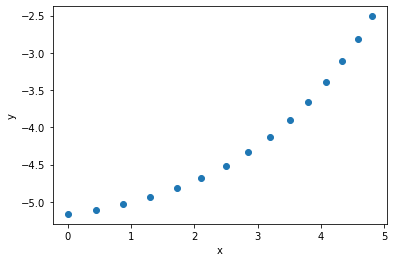

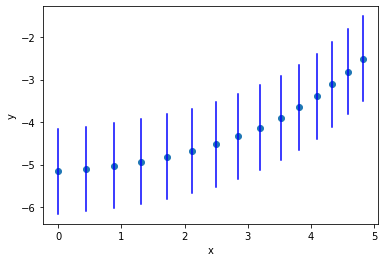

[-5.163543, -5.10562, -5.02956, -4.934649, -4.817297, -4.680938, -4.519193, -4.336344, -4.130089, -3.903866, -3.65638, -3.393066, -3.115393, -2.817803, -2.508137]


In [26]:
showResult(offsetDataX, dataY, beta0, beta1, beta2, h_up, h_down)
print(dataY)

In [27]:
coef = MNK(dataX, dataY)
coef = list(coef)
print("Beta0 = " + str(coef[0][0]))
print("Beta1 = " + str(coef[0][1]))
print("Beta2 = " + str(coef[0][2]))

Beta0 = 872.7788717161077
Beta1 = -21.061387491294827
Beta2 = 0.12632144310129886


In [28]:
check(dataX, dataY, h_up, h_down, coef[0][0], coef[0][1], coef[0][2])

(15, 0.18434712147651328)

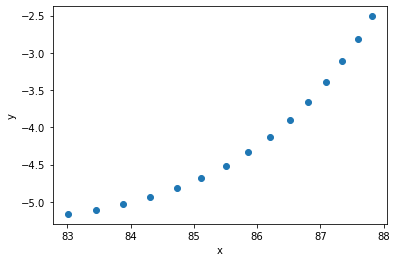

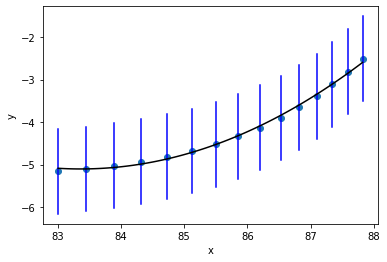

In [29]:
showResult(dataX, dataY, coef[0][0], coef[0][1], coef[0][2], h_up, h_down)

In [30]:
MSE(dataY, findResultY(dataX, coef[0][0], coef[0][1], coef[0][2]))

0.0022655907464450894

In [31]:
MSE(dataY, findResultY(offsetDataX, beta0, beta1,beta2))

0.0034784105445259026

In [32]:
MAE(dataY, findResultY(dataX, coef[0][0], coef[0][1], coef[0][2]))

0.041041322560630505

In [33]:
MAE(dataY, findResultY(offsetDataX, beta0, beta1,beta2))

0.05072415888331724

### Анализ всех данных

In [34]:
dataFile = ["gold_turn_00_0_15.txt",
           "gold_turn_00_6_15.txt",
           "gold_turn_01_15_15.txt",
           "gold_turn_02_20_15.txt",
           "gold_turn_02_23_15.txt",
           "gold_turn_02_34_15.txt",
           "gold_turn_02_46_15.txt",
           "gold_turn_03_00_15.txt",
           "gold_turn_05_0_15.txt",
           "gold_turn_05_3_15.txt",
           "gold_turn_05_6_15.txt"]

File = gold_turn_00_0_15.txt
system correct
system correct
system correct
Number of correct interval = 15
Norm2 = 0.22842101078466634
Equation = -5.163543 + -0.026581072232356284* x + 0.11735374950272665 * x^2


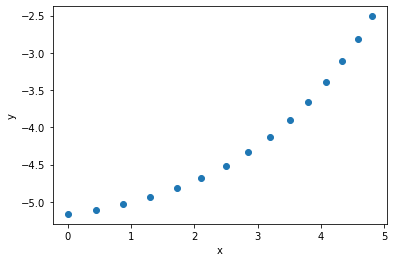

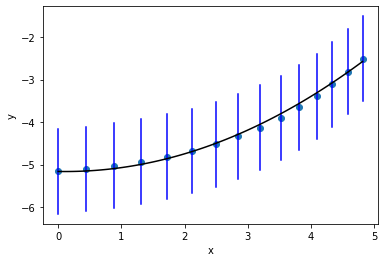

File = gold_turn_00_6_15.txt
system correct
system correct
system correct
Number of correct interval = 15
Norm2 = 1.2693518741625065
Equation = -170.00939734996155 + -4.724975539811652* x + 0.8385815118360357 * x^2


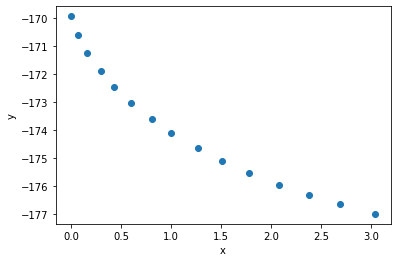

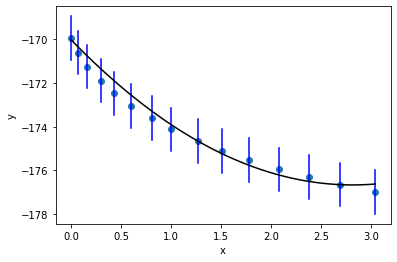

File = gold_turn_01_15_15.txt
system correct
system correct
system correct
Number of correct interval = 15
Norm2 = 0.1061511239486712
Equation = 1824.183 + 0.3755443519931645* x + -0.009665865276365277 * x^2


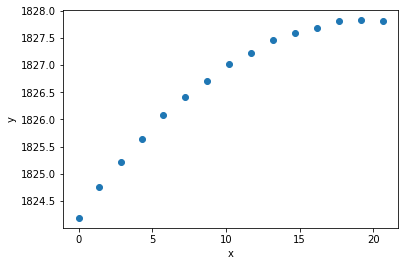

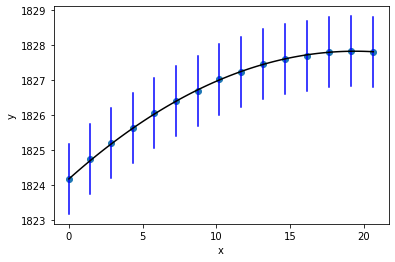

File = gold_turn_02_20_15.txt
system correct
system correct
system correct
Number of correct interval = 15
Norm2 = 0.09191279218486875
Equation = 495.765 + 0.4486705299407914* x + -0.044735368029727426 * x^2


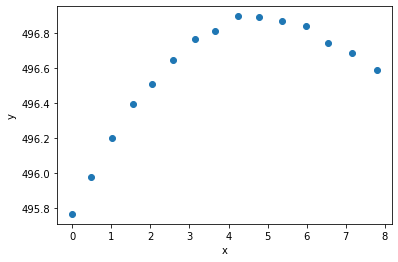

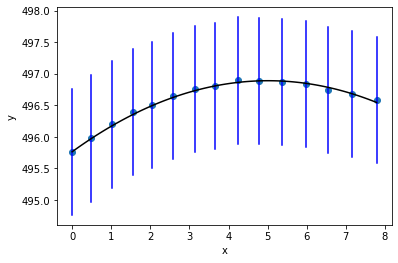

File = gold_turn_02_23_15.txt
the system is inconsistent
File = gold_turn_02_34_15.txt
system correct
system correct
system correct
Number of correct interval = 15
Norm2 = 0.12604953949907527
Equation = 365.7132 + 0.016042314711219585* x + -0.027416265805832583 * x^2


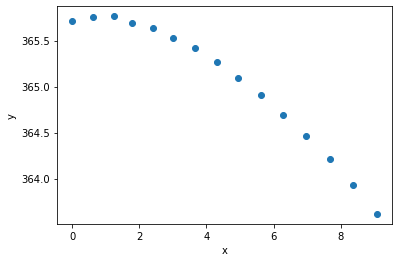

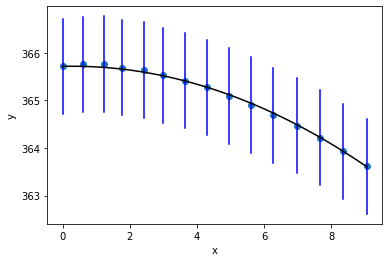

File = gold_turn_02_46_15.txt
system correct
system correct
system correct
Number of correct interval = 15
Norm2 = 0.0895110687567277
Equation = 250.2806 + 0.4886527604759233* x + -0.05563492606069416 * x^2


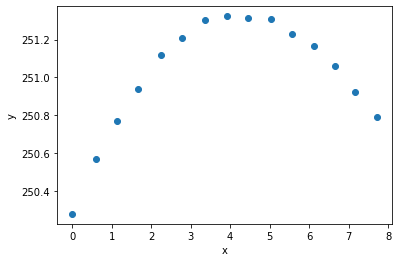

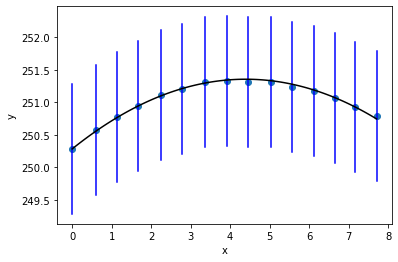

File = gold_turn_03_00_15.txt
system correct
system correct
system correct
Number of correct interval = 15
Norm2 = 1.8019750576479703
Equation = 1.9460800000000003 + -0.17382687921244777* x + 2.279581142710806 * x^2


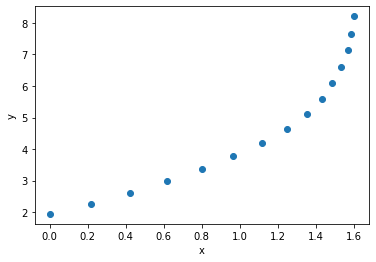

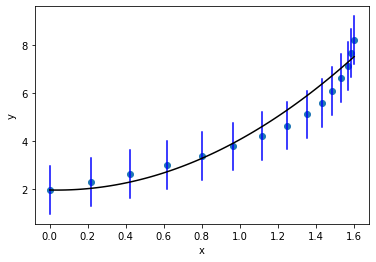

File = gold_turn_05_0_15.txt
system correct
system correct
system correct
Number of correct interval = 15
Norm2 = 0.35188171366943505
Equation = 189.5095 + 2.000123128099616* x + -0.20311473849409298 * x^2


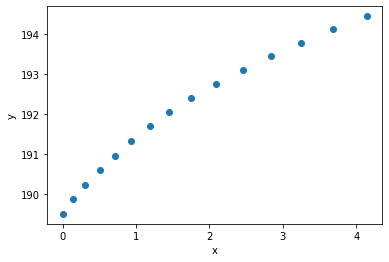

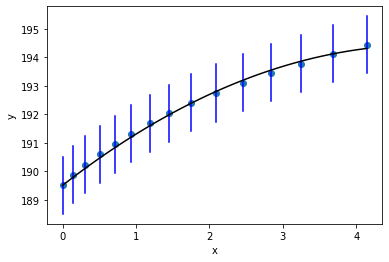

File = gold_turn_05_3_15.txt
system correct
system correct
system correct
Number of correct interval = 15
Norm2 = 0.3696838525399809
Equation = -4.639218 + 0.4844917087207996* x + 0.2801025987760263 * x^2


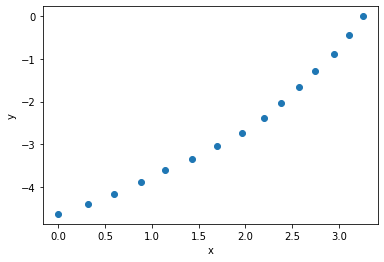

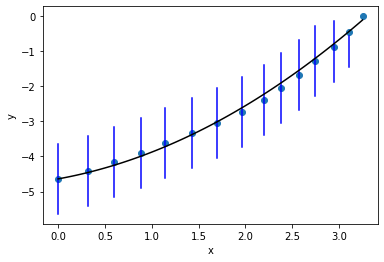

File = gold_turn_05_6_15.txt
system correct
system correct
system correct
Number of correct interval = 15
Norm2 = 0.06739843481436761
Equation = 226.043 + 0.10709050033658107* x + -0.03094069521829091 * x^2


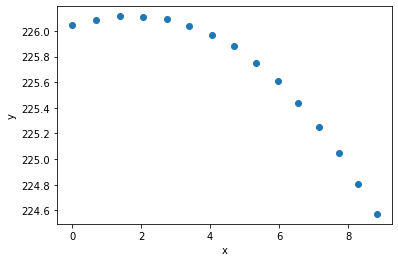

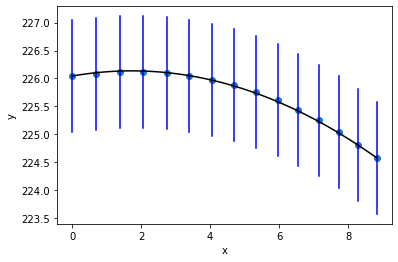

In [35]:
for i in range(len(dataFile)):
    print("File = " + dataFile[i])
    dataX, dataY, dataEps = readData(dataFile[i], True)
    offsetDataX = modifyX(dataX)
    h_down, h_up = findBoundariesUncertainty(dataY, dataEps)
    
    beta0, beta1, beta2, error = findAllCoeff(offsetDataX, dataY, h_up, h_down)
    
    if error == 0:
        correct, norm = check(offsetDataX, dataY, h_up, h_down, beta0, beta1, beta2)
        print("Number of correct interval = " + str(correct))
        print("Norm2 = " + str(norm))
        print("Equation = " + str(beta0) + " + " + str(beta1) + "* x + " + str(beta2) + " * x^2")
        showResult(offsetDataX, dataY, beta0, beta1, beta2, h_up, h_down)

File = gold_turn_02_23_15.txt
Number of correct interval = 0
Norm2 = 347.3187264470838
Equation = -3593100.0 + 13708* x + -13.073 * x^2


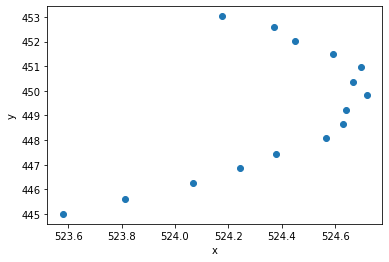

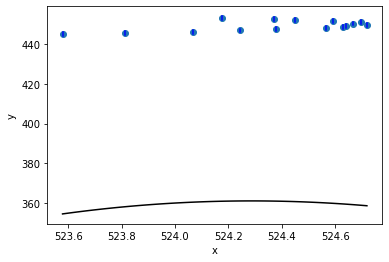

In [32]:
#1
#fileName = "gold_turn_00_0_15.txt"
#2
#fileName = "gold_turn_00_6_15.txt"
#3
#fileName = "gold_turn_01_15_15.txt"
#4
#fileName = "gold_turn_02_20_15.txt"
#5
#fileName = "gold_turn_02_34_15.txt"
#6
#fileName = "gold_turn_02_46_15.txt"
#7
#fileName = "gold_turn_03_00_15.txt"
#8
#fileName = "gold_turn_05_0_15.txt"
#9
#fileName = "gold_turn_05_3_15.txt"
#10
#fileName = "gold_turn_05_6_15.txt"

#11
fileName = "gold_turn_02_23_15.txt"



print("File = " + fileName)
dataX, dataY, dataEps = readData(fileName, False)
#offsetDataX = modifyX(dataX)
h_down, h_up = findBoundariesUncertainty(dataY, dataEps)
 
#beta0, beta1, beta2, error = findAllCoeff(offsetDataX, dataY, h_up, h_down)

#1
#beta0, beta1, beta2 =  887.68, -21.417, 0.12844
#2
#beta0, beta1, beta2 = 39387, -361.95, 0.8278
#3
#beta0, beta1, beta2 = -9450.2, -20.951, -0.0097
#4
#beta0, beta1, beta2 = -8058.1, 38.41, -0.0431
#5
#beta0, beta1, beta2 = -12268, 37.393, -0.0277
#6
#beta0, beta1, beta2 = -3935.2, 29.659, -0.052531
#7
#beta0, beta1, beta2 = 10557, -385.72, 3.5242
#8
#beta0, beta1, beta2 =  -1418.1, 34.683, -0.18648
#9
#beta0, beta1, beta2 = 16790, -145.98, 0.31723
#10
#beta0, beta1, beta2 =  -1019.1, 12.507, -0.0314

#11
beta0, beta1, beta2 =  -3.5931e+06, 13708, -13.073



if error == 0:
    correct, norm = check(dataX, dataY, h_up, h_down, beta0, beta1, beta2)
    print("Number of correct interval = " + str(correct))
    print("Norm2 = " + str(norm))
    print("Equation = " + str(beta0) + " + " + str(beta1) + "* x + " + str(beta2) + " * x^2")
    showResult(dataX, dataY, beta0, beta1, beta2, h_up, h_down)